In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os.path
import numpy as np
from matplotlib import pyplot as plt

from skimage import transform
from skimage.feature import peak_local_max
from graph import visualize_samples

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, Input, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from graph import plot_history, visualize_bboxes, visualize_heatmap, plot_precision_recall
from get_data import load_dataset, unpack
from scores import best_match, iou_score

In [3]:
train_images, train_bboxes, train_shapes = load_dataset("data", "train")
val_images, val_bboxes, val_shapes = load_dataset("data", "val")

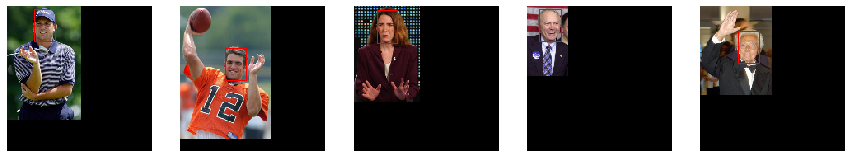

In [4]:
visualize_bboxes(images=train_images, true_bboxes=train_bboxes)

In [5]:
SAMPLE_SHAPE = (32, 32, 3)

In [6]:
def is_negative_bbox(new_bbox, true_bboxes, eps=1e-1):
    """Check if new bbox not in true bbox list.
    
    There bbox is 4 ints [min_row, min_col, max_row, max_col] without image index."""
    for bbox in true_bboxes:
        if iou_score(new_bbox, bbox) >= eps:
            return False
    return True

In [7]:
# Write this function
def gen_negative_bbox(image_shape, bbox_size, true_bboxes):
    """Generate negative bbox for image."""
    height, width = bbox_size
    min_row = np.random.choice(image_shape[0] - height)
    max_row = min_row + height
    min_col = np.random.choice(image_shape[1] - width)
    max_col = min_col + width
    return [min_row, min_col, max_row, max_col]

def get_positive_negative(images, true_bboxes, image_shapes, negative_bbox_count=None):
    """Retrieve positive and negative samples from image."""
    positive = []
    negative = []
    image_count = image_shapes.shape[0]
    
    if negative_bbox_count is None:
        negative_bbox_count = len(true_bboxes)
    
    # Pay attention to the fact that most part of image may be black -
    # extract negative samples only from part [0:image_shape[0], 0:image_shape[1]]
    
    for true_bbox in true_bboxes:        
        image_index = true_bbox[0]
        pos_img = images[image_index][true_bbox[1]:true_bbox[1]+32, true_bbox[2]:true_bbox[2]+32, :]
        positive.append(pos_img)
        
    for i in range(negative_bbox_count):
        image_index = np.random.choice(len(images))
        image_shape = image_shapes[image_index]
        image_true_bboxes = true_bboxes[true_bboxes[:, 0] == image_index, 1:]
        for j in range(100):
            bbox_size = (32, 32)
            new_bbox = gen_negative_bbox(image_shape, bbox_size, image_true_bboxes)
            if is_negative_bbox(new_bbox, image_true_bboxes):
                neg_img = images[image_index][new_bbox[0]:new_bbox[2], new_bbox[1]:new_bbox[3]]
                negative.append(neg_img)
                break
   
    return positive, negative

In [8]:
def get_samples(images, true_bboxes, image_shapes):
    """Usefull samples for learning.
    
    X - positive and negative samples.
    Y - one hot encoded list of zeros and ones. One is positive marker.
    """
    positive, negative = get_positive_negative(images=images, true_bboxes=true_bboxes, 
                                               image_shapes=image_shapes)
    X = positive
    Y = [[0, 1]] * len(positive)
    
    X.extend(negative)
    Y.extend([[1, 0]] * len(negative))
    
    return np.array(X), np.array(Y)

In [9]:
X_train, Y_train = get_samples(train_images, train_bboxes, train_shapes)
X_val, Y_val = get_samples(val_images, val_bboxes, val_shapes)

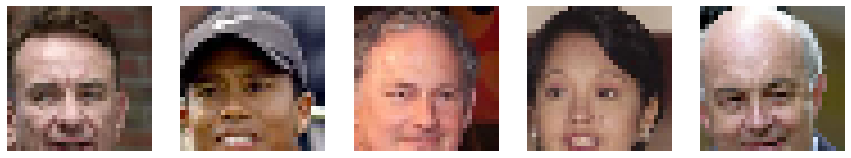

In [10]:
# There we should see faces
visualize_samples(X_train[Y_train[:, 1] == 1])

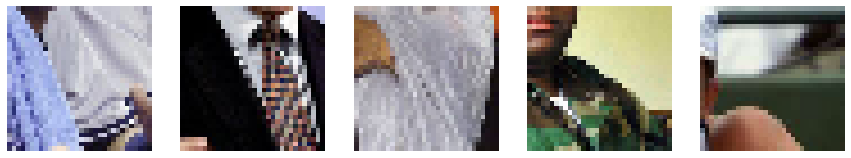

In [11]:
# There we shouldn't see faces
visualize_samples(X_train[Y_train[:, 1] == 0])


In [12]:
BATCH_SIZE = 64

In [13]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.1)
datagen.fit(X_train)

In [14]:
def fit(model, datagen, X_train, Y_train, X_val, Y_val, model_name=None, output_dir="data/checkpoints", class_weight=None, epochs=50, lr=0.001, verbose=False):
   
    
    if verbose:
        model.summary()

    model.compile(optimizer=Adam(lr=lr), # You can use another optimizer
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    
    history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                                  validation_data=(datagen.standardize(X_val), Y_val),
                                  epochs=epochs, steps_per_epoch=len(X_train) // BATCH_SIZE,
                                  callbacks=[ModelCheckpoint(os.path.join(output_dir, "{model_name}").format(model_name=model_name) + "-{epoch:02d}-{val_loss:.2f}.hdf5", save_best_only=True),
                                            ] if model_name is not None else [],
                                  class_weight=class_weight,
                      
                                 )  # starts training
    
    plot_history(history)

In [15]:
def generate_model(sample_shape):
    # Classification model
    # You can start from LeNet architecture
    x = inputs = Input(shape=sample_shape)

    # Write code here
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)

    # This creates a model
    predictions = Dense(2, activation='softmax')(x)
    return Model(inputs=inputs, outputs=predictions)

model = generate_model(SAMPLE_SHAPE)

In [23]:
# Attention: Windows implementation may cause an error here. In that case use model_name=None.
fit(model_name="None", model=model, datagen=datagen, X_train=X_train, X_val=X_val, Y_train=Y_train, Y_val=Y_val)

Epoch 1/50
30/30 [==============================] - 6s 212ms/step - loss: 8.7143 - accuracy: 0.4584 - val_loss: 8.1735 - val_accuracy: 0.4607
Epoch 2/50
30/30 [==============================] - 6s 208ms/step - loss: 8.7197 - accuracy: 0.4638 - val_loss: 8.1735 - val_accuracy: 0.4607
Epoch 3/50
30/30 [==============================] - 6s 203ms/step - loss: 8.7217 - accuracy: 0.4568 - val_loss: 8.1735 - val_accuracy: 0.4607
Epoch 4/50
30/30 [==============================] - 6s 204ms/step - loss: 8.7417 - accuracy: 0.4590 - val_loss: 8.1735 - val_accuracy: 0.4607
Epoch 5/50
30/30 [==============================] - 7s 218ms/step - loss: 8.8162 - accuracy: 0.4531 - val_loss: 8.4620 - val_accuracy: 0.4607
Epoch 6/50
30/30 [==============================] - 6s 201ms/step - loss: 8.4677 - accuracy: 0.4723 - val_loss: 7.9130 - val_accuracy: 0.5408
Epoch 7/50
30/30 [==============================] - 6s 209ms/step - loss: 7.2911 - accuracy: 0.5474 - val_loss: 7.6561 - val_accuracy: 0.5393
Epoch 

KeyError: 'acc'

In [18]:
def get_checkpoint():
    return "data/checkpoints/lenet-01-8.17.hdf5"

model.load_weights(get_checkpoint())

In [24]:
# FCNN

IMAGE_SHAPE = (176, 176, 3)

def generate_fcnn_model(image_shape):
    """After model compilation input size cannot be changed.
    
    So, we need create a function to have ability to change size later.
    """
    x = inputs = Input(image_shape)

    # Write code here
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (8, 8), activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = Dropout(0.25)(x)

    # This creates a model
    predictions = Conv2D(2, (1, 1), activation='linear')(x)
    return Model(inputs=inputs, outputs=predictions)

fcnn_model = generate_fcnn_model(IMAGE_SHAPE)

In [25]:
def copy_weights(base_model, fcnn_model):
    """Set FCNN weights from base model.
    """
    
    new_fcnn_weights = []
    prev_fcnn_weights = fcnn_model.get_weights()
    prev_base_weights = base_model.get_weights()
    
    # Write code here
    for prev_fcnn_weight, prev_base_weight in zip(prev_fcnn_weights, prev_base_weights):
        new_fcnn_weights.append(prev_base_weight.reshape(prev_fcnn_weight.shape))
        
    fcnn_model.set_weights(new_fcnn_weights)

copy_weights(base_model=model, fcnn_model=fcnn_model)

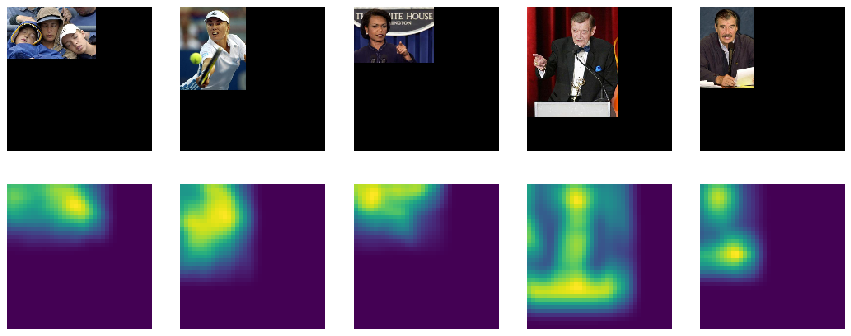

In [26]:
predictions = fcnn_model.predict(np.array(val_images))
visualize_heatmap(val_images, predictions[:, :, :, 1])

In [27]:
def get_bboxes_and_decision_function(fcnn_model, images, image_shapes):      
    cropped_images = np.array([transform.resize(image, IMAGE_SHAPE, mode="reflect")  if image.shape != IMAGE_SHAPE else image for image in images])
    pred_bboxes, decision_function = [], []
   
    # Predict
    predictions = fcnn_model.predict(cropped_images)

    # Write code here
    for i in range(len(predictions)):
        img_shape = image_shapes[i]
        local_max_list = peak_local_max(predictions[i][:,:,1], num_peaks=5, min_distance=3, exclude_border=False)
        for local_max_orig in local_max_list:
            local_max = ((local_max_orig + 2)*176/37).astype(int)
            
            if local_max[0] < img_shape[0] and local_max[1] < img_shape[1]:
                bbox = [i] + [local_max[0]-16,local_max[1]-16,local_max[0]+16,local_max[1]+16]
                
                pred_bboxes.append(bbox)
                decision_function.append(predictions[i, local_max_orig[0], local_max_orig[1], 1])
        
    return pred_bboxes, decision_function

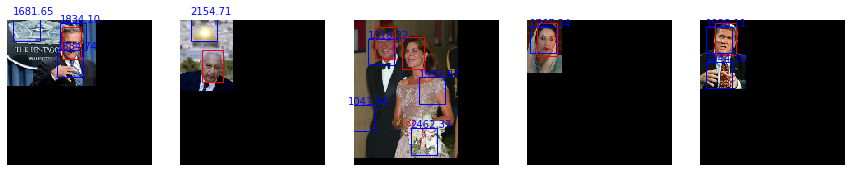

In [28]:
pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes)

visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function)

In [30]:
def precision_recall_curve(pred_bboxes, true_bboxes, decision_function):
    precision, recall, thresholds = [], [], []
    
    # Write code here
    threshold = min(decision_function) - 1
    max_th = max(decision_function) + 1
    num_steps = 100
    th_step = (max_th - threshold)/num_steps

    sorted_boxes = [[x]+y for y,x in sorted(zip(pred_bboxes,decision_function),key=lambda pair:pair[1])]
    
    for step in range(num_steps):        
        pred_bboxes_th = [x[1:] for x in sorted_boxes if x[0]>threshold]
        if len(pred_bboxes_th) > 0:
            matched, false_negative, false_positive = best_match(pred_bboxes_th, true_bboxes, decision_function)
        else:
            break
        
        prec = len(matched)/(len(matched)+len(false_positive))
        rec = len(matched)/(len(matched)+len(false_negative))
        
        thresholds.append(threshold)
        recall.append(rec)
        precision.append(prec)
        threshold += th_step
    
    return precision, recall, thresholds

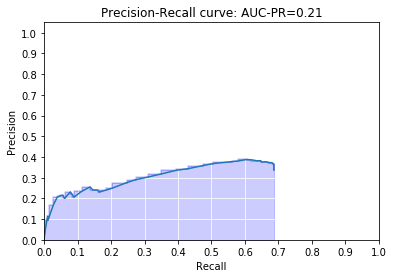

In [31]:
precision, recall, thresholds = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

In [32]:
def get_threshold(thresholds, recall):
    return thresholds[np.argmax(np.asarray(recall) <= 0.85)]

THRESHOLD = get_threshold(thresholds, recall)

In [33]:
def detect(fcnn_model, images, image_shapes, threshold, return_decision=True):
    """Get bboxes with decision_function not less then threshold."""
    pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model, images, image_shapes)   
    result, result_decision = [], []
    
    # Write code here
    for i in range(len(pred_bboxes)):
        if decision_function[i] >= threshold:
            result.append(pred_bboxes[i])
            result_decision.append(decision_function[i])
    
    if return_decision:
        return result, result_decision
    else:
        return result

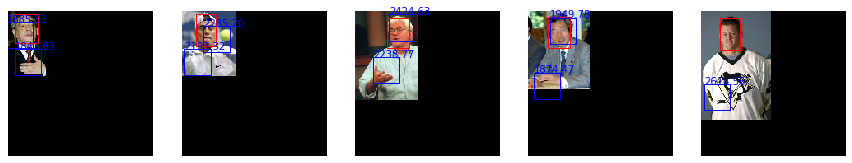

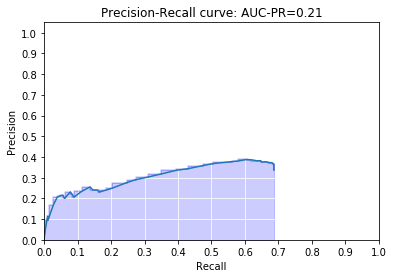

In [34]:
pred_bboxes, decision_function = detect(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes, threshold=THRESHOLD, return_decision=True)

visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function)

precision, recall, thresholds = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

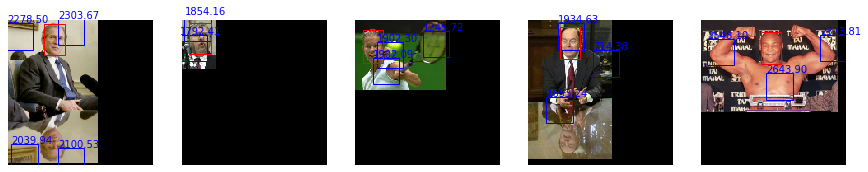

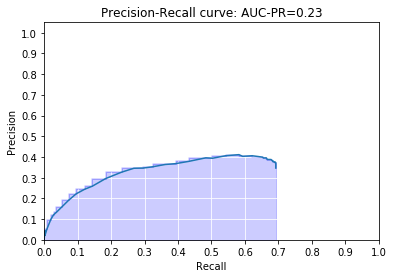

In [35]:
test_images, test_bboxes, test_shapes = load_dataset("data", "test")

# We test get_bboxes_and_decision_function becouse we want pay attention to all recall values
pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model, images=test_images, image_shapes=test_shapes)

visualize_bboxes(images=test_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=test_bboxes,
                 decision_function=decision_function)

precision, recall, threshold = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=test_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)